# Figure Generation Code: planet_tile2img

In [23]:
import rasterio as rio
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import pandas as pd
import numpy as np

import xarray as xr
import cmocean
import fiona
from matplotlib import colors
from rasterio.plot import show
from rasterio.windows import from_bounds, transform

from datetime import datetime
import csv

## Build Velocity Rastor Comparison Between S2 and PS

In [52]:
# Import Velocity Rastors
S2_raster_path = '/Volumes/LaCie/SK_vmaps_2020_2021/velocity_20200904_20200914_100m_S2.tif'
PS_raster_path = '/Volumes/LaCie/autorift_OUTPUT_PSsurge/velocity_20200906_20200912_100m_PS.tif'


#sentinel2
S2_reader = rio.open(S2_raster_path);
S2r = S2_reader.read(3);

#planetscope
PS_reader = rio.open(PS_raster_path); 
PSr = PS_reader.read(3)
    
# grab window into raster
window = from_bounds(left, bottom, right, top, S2_reader.transform) 

# Subtract The Rasters
difference_raster = S2r_data - PSr_data

In [131]:
# # window bounds(UTM coordinates - SK):
left = 555800
right = 581000
top = 6.675e6
bottom = 6.650e6

# manually set consistent tickmarks
yticks_m = np.array([6.655e6, 6.665e6, 6.675e6])
yticks_km = np.array(yticks_m/1000).astype(int)
xticks_m = np.array([560e3, 570e3, 580e3])
xticks_km = np.array(xticks_m/1000).astype(int)

print(difference_raster.shape)

# CROPPING
y1 = 75; y2 = y1+255
x1 = 100; x2 = 90+270
xticks_idx = np.array([43, 150, 248])
yticks_idx = np.array([205, 103, 0])

diff_cropped = difference_raster[y1:y2, x1:x2]
print(diff_cropped.shape)

(414, 416)
(255, 260)


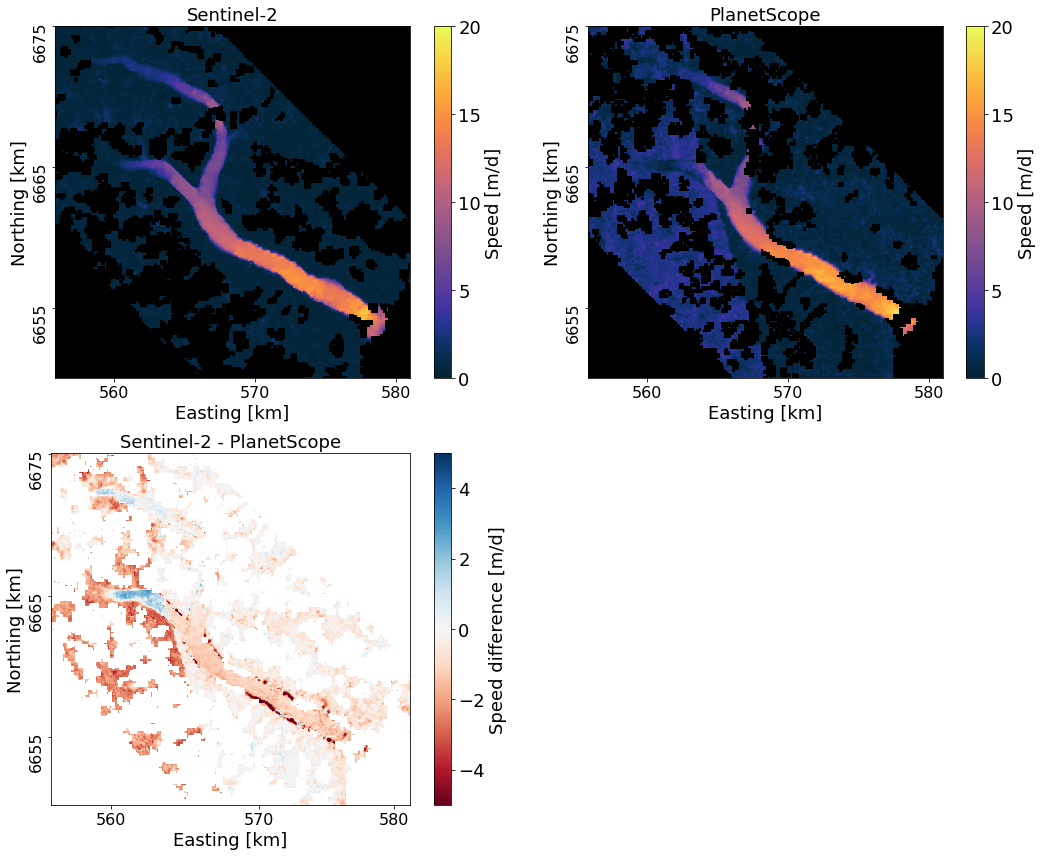

In [136]:
# Build Figures
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(15, 12))

# Set the spacing between subplots
# plt.subplots_adjust(hspace=0.2)

#sentinel 2
im1 = ax1.imshow(S2_reader.read(window=window)[2]/365,cmap=cmocean.cm.thermal, 
                            vmin=0, vmax=20)
# map:
show(S2_reader.read(window=window)[2],
     transform = transform(window, S2_reader.transform), # use window transform
     cmap = cmocean.cm.thermal,
     vmin=0, vmax=20*365,
     ax=ax1)
ax1.set_title('Sentinel-2', fontsize=fs)
cbar = fig.colorbar(im1,ax=ax1)
cbar1 = cbar.ax.tick_params(labelsize = fs)
cbar.set_ticks([0,5,10,15,20])
cbar.set_label('Speed [m/d]',fontsize=fs)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Easting [km]',fontsize=fs)
    ax.set_ylabel('Northing [km]',fontsize=fs)
    ax.tick_params(axis='both',labelsize=fs-2)
    
    # manually set consistent tickmarks
    ax.set_yticks(yticks_m); ax.set_yticklabels(yticks_km, rotation=90)
    ax.set_xticks(xticks_m); ax.set_xticklabels(xticks_km)
    ax.set_facecolor('black')


#planetscope
im2 = ax2.imshow(PS_reader.read(window=window)[2]/365,cmap=cmocean.cm.thermal, 
                            vmin=0, vmax=20)
# map:
show(PS_reader.read(window=window)[2],
     transform = transform(window, PS_reader.transform), # use window transform
     cmap = cmocean.cm.thermal,
     vmin=0, vmax=20*365,
     ax=ax2)
ax2.set_title('PlanetScope', fontsize=fs)
cbar = fig.colorbar(im2, ax=ax2)
cbar.ax.tick_params(labelsize = fs)
cbar.set_label('Speed [m/d]',fontsize=fs)
cbar.set_ticks([0,5,10,15,20])
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15); plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs-2)

#difference raster
im3 = ax3.imshow(diff_cropped/365,cmap='RdBu',vmin=-5, vmax=5)
ax3.set_xticks(xticks_idx); ax3.set_yticks(yticks_idx)
ax3.set_title('Sentinel-2 - PlanetScope', fontsize=fs)
ax3.set_yticklabels(yticks_km, rotation=90); ax3.set_xticklabels(xticks_km)
cbar = fig.colorbar(im3,ax=ax3)
cbar.ax.tick_params(labelsize = fs)
cbar.set_label('Speed difference [m/d]',fontsize=fs)
plt.xlabel('Easting [km]',fontsize=fs, labelpad = 15)
plt.ylabel('Northing [km]',fontsize=fs, labelpad = 15)
plt.tick_params(axis='both',labelsize=fs-2)   
ax3.set_facecolor('white')

# Save the figure (one at a time)
ax4.axis('off')
plt.tight_layout()
# plt.savefig('/Users/maddiegendreau/Desktop/PS_S2_Velocity_Difference.png', dpi=300)
plt.savefig('/Users/jukesliu/Documents/PLANETSCOPE_VELOCITIES/figures/PS_S2_Velocity_Difference.png',dpi=300)
plt.show()


## Generate Errors BoxPlot

In [3]:
# Call in CSV files for all error data
data1 = pd.read_csv('/Volumes/Gendreau/Documents/CSVs/LS_Data.csv')['err_v']
data2 = pd.read_csv('/Volumes/Gendreau/Documents/CSVs/S1_Data.csv')['err_v']
data3 = pd.read_csv('/Volumes/Gendreau/Documents/CSVs/S2_Data.csv')['err_v']
data4 = pd.read_csv('/Volumes/Gendreau/Documents/new_csv/PS_new.csv')['err_v']
data = [data1, data2, data3, data4]

# set potions and labels for the data
positions = [1, 2, 3, 4]
labels = ['Landsat', 'Sentinel-1', 'Sentinel-2', 'PlanetScope']

# plot and save
fs = 16
plt.boxplot(data, positions=positions, labels=labels)
plt.figure(figsize=(8,8))
plt.xlabel('Satellite', fontsize=fs)
plt.ylabel('Speed error [m/d]', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.tight_layout()
# Save the figure, you'll need to change the path to the desired figure location
plt.savefig('/Users/jukesliu/Documents/PLANETSCOPE_VELOCITIES/figures/error_boxplot.png', dpi=200)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Gendreau/Documents/CSVs/LS_Data.csv'

## Create histograms of date separation

In [193]:
# Go to folder with the autoRIFT output tif files
folder_path = '/Volumes/LaCie/autorift_OUTPUT_PSsurge_SK/'
prefix = "velocity"
suffix = "100m_PS.tif"

# # FOR S2, L8:
# # Go to folder with the autoRIFT output tif files
# folder_path = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/output_autoRIFT/'
# prefix = "velocity"

# Find the tif files you want to use
date_separations = []
months = []
for file in os.listdir(folder_path):
    if file.startswith(prefix) and file.endswith(suffix):
#     if file.startswith(prefix) and (file.endswith('100m_S2.tif') or 
#                                     file.endswith('100m_LS.tif')):
        [pre, ds1, ds2, chipsize, sat] = file.split('_')
        
        if ds2.startswith('2020') or ds2.startswith('2021'):
            print(file)
            dt = pd.to_datetime(ds2) - pd.to_datetime(ds1)
            date_separations.append(dt.days)
            months.append(int(ds1[4:6]))

velocity_20211010_20211016_100m_PS.tif
velocity_20200627_20200805_100m_PS.tif
velocity_20210617_20210629_100m_PS.tif
velocity_20200329_20200411_100m_PS.tif
velocity_20210415_20210425_100m_PS.tif
velocity_20210401_20210415_100m_PS.tif
velocity_20200906_20200912_100m_PS.tif
velocity_20200912_20201013_100m_PS.tif
velocity_20210821_20210830_100m_PS.tif
velocity_20210425_20210604_100m_PS.tif
velocity_20210907_20210918_100m_PS.tif
velocity_20210830_20210907_100m_PS.tif
velocity_20200805_20200906_100m_PS.tif
velocity_20200411_20200425_100m_PS.tif
velocity_20210211_20210401_100m_PS.tif
velocity_20201105_20201110_100m_PS.tif
velocity_20210815_20210821_100m_PS.tif
velocity_20200213_20200305_100m_PS.tif
velocity_20210918_20211005_100m_PS.tif
velocity_20210704_20210716_100m_PS.tif
velocity_20210629_20210704_100m_PS.tif
velocity_20200528_20200627_100m_PS.tif
velocity_20200425_20200512_100m_PS.tif
velocity_20210604_20210609_100m_PS.tif
velocity_20201110_20201116_100m_PS.tif
velocity_20200305_2020031

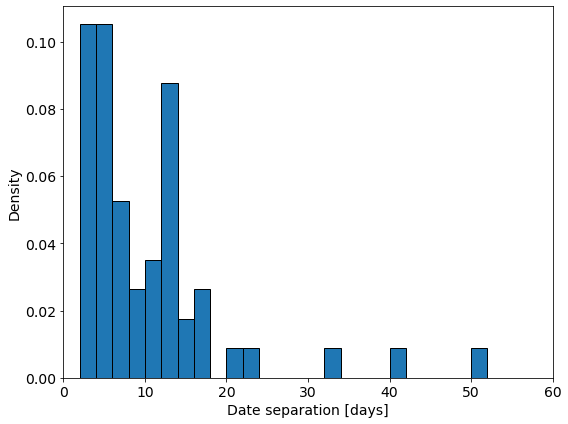

In [169]:
# plot histogram
fs = 14
plt.figure(figsize=(8,6))
plt.hist(date_separations,bins=np.arange(0,60,2),density=True,edgecolor='black')
plt.xlim(0,60)
plt.tick_params(labelsize=fs)
# plt.ylim(0,16)
plt.xlabel('Date separation [days]', fontsize=fs); plt.ylabel('Density', fontsize=fs)
plt.tight_layout()
# plt.savefig('/Users/jukesliu/Documents/PLANETSCOPE_VELOCITIES/figures/histogram_dt_PS.png',dpi=300)
plt.show()

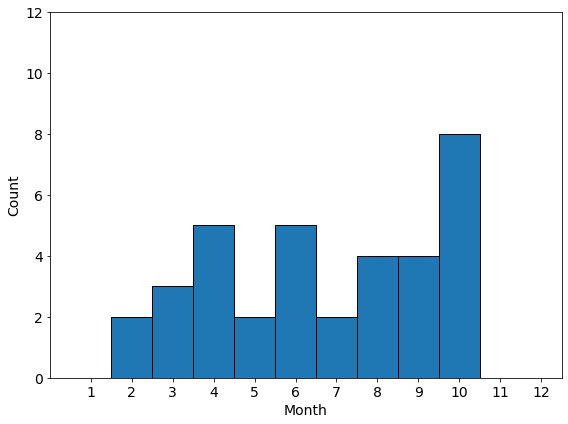

In [194]:
# plot histogram
fs = 14
plt.figure(figsize=(8,6))
plt.hist(months,bins=np.arange(1,12,1),edgecolor='black',align='left')
plt.xlim(0,12.5)
plt.xticks(np.arange(1,13,1))
plt.tick_params(labelsize=fs)
plt.ylim(0.5,12)
plt.xlabel('Month', fontsize=fs); plt.ylabel('Count', fontsize=fs)
plt.tight_layout()
plt.savefig('/Users/jukesliu/Documents/PLANETSCOPE_VELOCITIES/figures/histogram_month_PS.png',dpi=300)
plt.show()